In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpmath import mp
import mpmath

In [288]:
def initialize_cosine_potential(J: float, max_s: int = 10) -> np.ndarray:
    """
    Initialize Fourier coefficients for u(θ) = exp[J cos(θ) - J]
    Based on Eq. 2.2 and discussion around Eq. 2.6 in the paper
    
    Args:
        J: Initial coupling strength
        max_s: Maximum Fourier mode to track
    Returns:
        Array of Fourier coefficients f(s) from -max_s to max_s
    """
    # Use high precision
    mpmath.mp.dps = 50  
    
    # Convert J to mpmath type
    J = mpmath.mpf(str(J))
    
    # Initialize array for 2*max_s + 1 coefficients
    f = np.zeros(2*max_s + 1, dtype=object)
    
    # Number of points for numerical integration
    n_points = 1000
    # Use mpmath's linspace
    theta = [mpmath.mpf(t) for t in mpmath.linspace(0, 2*mpmath.pi, n_points)]
    dtheta = mpmath.mpf('2.0') * mpmath.pi / mpmath.mpf(str(n_points))
    
    # Compute u(θ) = exp[J cos(θ) - J]
    u_theta = [mpmath.exp(J * (mpmath.cos(t) - 1)) for t in theta]
    
    # Compute Fourier coefficients
    for idx, s in enumerate(range(-max_s, max_s + 1)):
        s = mpmath.mpf(str(s))
        integrand = [u * mpmath.exp(-1j * s * t) for u, t in zip(u_theta, theta)]
        f[idx] = sum(integrand) * dtheta / (2*mpmath.pi)
    
    return f

def compute_g(f: np.ndarray, max_s: int) -> np.ndarray:
    """
    Compute g(s) = Fourier transform of u²(θ)
    Based on Eq. 2.7b
    """
    g = np.zeros(2*max_s + 1, dtype=object)
    
    for idx_s, s in enumerate(range(-max_s, max_s + 1)):
        g_s = mpmath.mpc(0)
        for p in range(-max_s, max_s + 1):
            q = s - p
            if abs(q) <= max_s:
                p_idx = p + max_s
                q_idx = q + max_s
                g_s += f[p_idx] * f[q_idx]
        g[idx_s] = g_s
        
    return g

def compute_A4(g: np.ndarray) -> mpmath.mpf:
    """
    Compute A4 = Σg²(s)
    Based on Eq. 2.9
    """
    return sum(g[s] * mpmath.conj(g[s]) for s in range(len(g)))

def rg_step(f: np.ndarray, max_s: int) -> np.ndarray:
    """
    Perform one RG transformation step
    Based on Eqs. 2.7a and 2.8
    """
    g = compute_g(f, max_s)
    A4 = compute_A4(g)
    
    f_new = np.zeros(2*max_s + 1, dtype=object)
    
    # Compute non-zero modes
    for idx, s in enumerate(range(-max_s, max_s + 1)):
        if s != 0:
            f_new[idx] = (g[idx] * g[idx]) / A4
    
    # Compute s=0 mode from normalization condition
    f_new[max_s] = mpmath.mpc(1.0) - sum(f_new[i] for i in range(len(f_new)) if i != max_s)
    
    return f_new

def rg_flow(J: float, n_steps: int = 10, max_s: int = 10) -> np.ndarray:
    """
    Run RG transformation for n steps
    """
    f = initialize_cosine_potential(J, max_s)
    history = [f.copy()]
    
    for _ in range(n_steps):
        f = rg_step(f, max_s)
        history.append(f.copy())
        
    return np.array(history)

def reconstruct_potential(f: np.ndarray, max_s: int, n_points: int = 1000):
    """
    Reconstruct u(θ) from Fourier coefficients
    
    Args:
        f: Array of Fourier coefficients f(s) from -max_s to max_s
        max_s: Maximum Fourier mode
        n_points: Number of points for θ
    
    Returns:
        theta: Array of angles from 0 to 2π
        u_theta: Reconstructed potential values
    """
    # Create theta points using mpmath
    theta = [mpmath.mpf(t) for t in mpmath.linspace(0, 2*mpmath.pi, n_points)]
    
    # Initialize potential array
    u_theta = [mpmath.mpc(0) for _ in range(n_points)]
    
    # Sum over all modes
    for idx_t, t in enumerate(theta):
        for idx_s, s in enumerate(range(-max_s, max_s + 1)):
            s = mpmath.mpf(str(s))
            u_theta[idx_t] += f[idx_s] * mpmath.exp(1j * s * t)
            
    # Convert to real values (potential should be real)
    u_theta = [float(mpmath.re(u)) for u in u_theta]
    theta = [float(t) for t in theta]
    
    return theta, u_theta

def plot_rg_flow_coefficients(history, J: float, n_steps: int = 20, max_s: int = 10):
    """
    Plot evolution of Fourier coefficients during RG flow
    
    Args:
        J: Initial coupling strength
        n_steps: Number of RG steps
        max_s: Maximum Fourier mode
    """
    
    plt.figure(figsize=(10, 6))
    
    # Plot evolution of first few modes
    modes_to_plot = [0, 1, 2, 3]  # Corresponds to s = 1,2,3
    for mode in modes_to_plot:
        # Get mode index (accounting for array structure -max_s to max_s)
        mode_idx = max_s + mode
        # Extract coefficient magnitudes
        flow = [float(abs(step[mode_idx])) for step in history]
        plt.plot(flow, label=f'mode {mode}')
    
    plt.xlabel('RG step')
    plt.ylabel('|f(s)|')
    plt.yscale('log')
    plt.legend()
    plt.grid(True)
    plt.title(f'RG Flow of Fourier Coefficients (J={J})')
    plt.show()

def plot_potential_evolution(history, J: float, n_steps: int = 20, max_s: int = 10, 
                           n_plot_steps: int = None):
    """
    Plot evolution of potential u(θ) during RG flow
    
    Args:
        J: Initial coupling strength
        n_steps: Number of RG steps
        max_s: Maximum Fourier mode
        n_plot_steps: Number of RG steps to plot. If None, plots every step
    """
    
    # If steps not specified, choose evenly spaced steps
    if n_plot_steps is None:
        steps_to_plot = np.linspace(0, len(history)-1, len(history)).astype(int)
    else:
        steps_to_plot = np.linspace(0, len(history)-1, n_plot_steps).astype(int)
    
    plt.figure(figsize=(10, 6))
    
    # Plot potential at selected steps
    colors = plt.cm.viridis(np.linspace(0, 1, len(steps_to_plot)))
    
    for idx, step in enumerate(steps_to_plot):
        theta, u_theta = reconstruct_potential(history[step], max_s)
        plt.plot(theta, u_theta, label=f'RG iteration {step}', color=colors[idx], alpha=0.7)
    
    plt.xlabel(r'$\theta$')
    plt.ylabel(r'$u(\theta)$')
    plt.title(f'Evolution of potential under RG transformation (J={J})')
    plt.legend()
    plt.grid(True)
    plt.show()

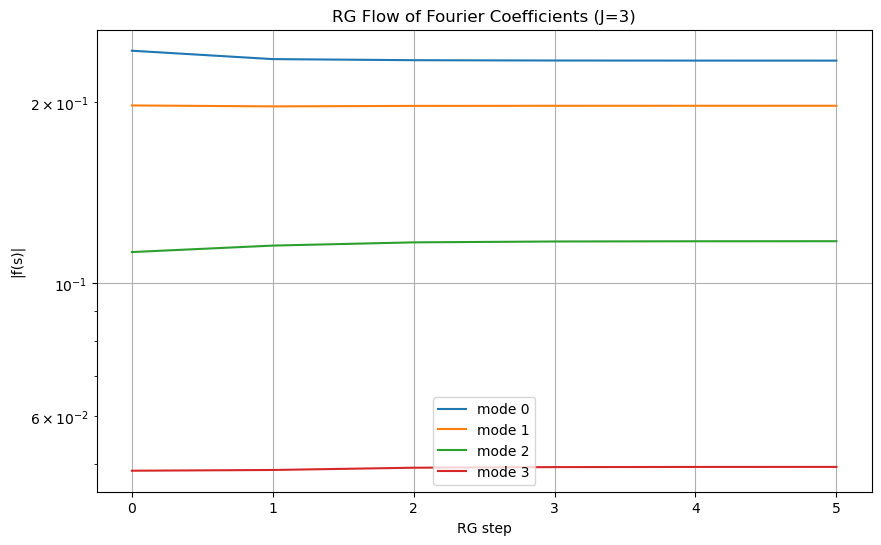

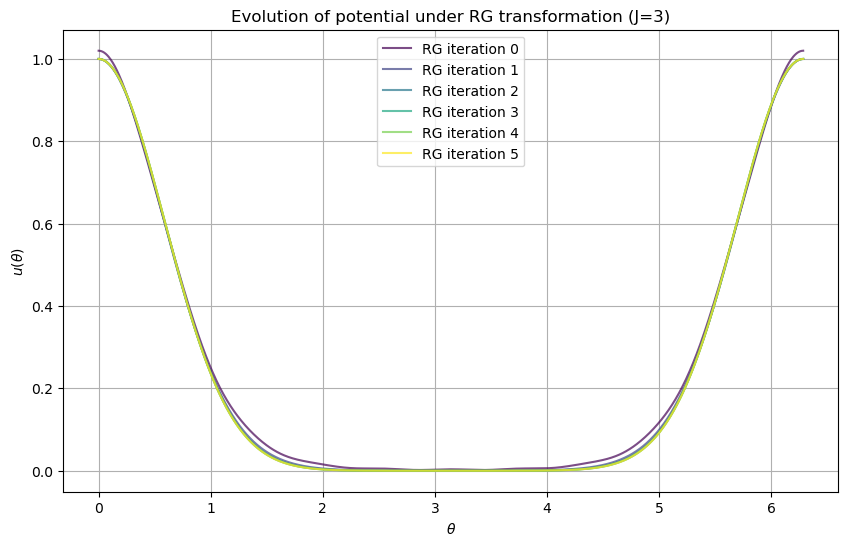

In [296]:
J = 3  # Initial coupling
history = rg_flow(J, 5, max_s)

# Plot coefficient evolution
plot_rg_flow_coefficients(history, J)

# Plot potential evolution
plot_potential_evolution(history, J)